In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_excel("../Data/E-Commerce_train.xlsx")
data.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [3]:
data['Warehouse_block'].value_counts()

F    2999
D    1500
A    1500
B    1500
C    1500
Name: Warehouse_block, dtype: int64

## Captamos los datos categoricos y numericos

#### Categoricos

In [4]:
categoricos = [cat for cat in data.columns if data[cat].dtype == 'object' and data[cat].nunique() <= 5]

In [5]:
categoricos

['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']

#### Numericos

In [6]:
numericos = [num for num in data.columns if data[num].dtype != 'object']

In [7]:
numericos

['ID',
 'Customer_care_calls',
 'Customer_rating',
 'Cost_of_the_Product',
 'Prior_purchases',
 'Discount_offered',
 'Weight_in_gms',
 'Reached.on.Time_Y.N']

#### Eliminamos la columna ID la cual no ayudara en el modelo y tambien elimino la variable objetivo

In [8]:
numericos.remove("ID")
numericos.remove("Reached.on.Time_Y.N")

In [9]:
numericos

['Customer_care_calls',
 'Customer_rating',
 'Cost_of_the_Product',
 'Prior_purchases',
 'Discount_offered',
 'Weight_in_gms']

In [10]:
complet = numericos + categoricos

## Separamos en variable objetivo y caracteristicas

In [11]:
X = data[complet]
y = data['Reached.on.Time_Y.N']

## Separamos la data en datos de entrenamientos y de prueba

In [12]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(X,y,test_size=0.4,random_state=1)

In [13]:
train_x.shape,test_x.shape, train_y.shape, test_y.shape

((5399, 10), (3600, 10), (5399,), (3600,))

## Funcion que estandarizacion y calcule el RECALL

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

In [15]:
def estandarizar(train,test):
    standar = StandardScaler()
    train_x_scaler = pd.DataFrame(standar.fit_transform(train))
    test_x_scaler = pd.DataFrame(standar.transform(test))
    train_x_scaler.columns = train.columns
    train_x_scaler.index = train.index
    test_x_scaler.columns = test.columns
    test_x_scaler.index = test.index
    return (train_x_scaler,test_x_scaler)

In [16]:
def evaluarModeloRL(train,test):
    modelo = LogisticRegression(random_state=1)
    modelo.fit(train,train_y)
    prediction = modelo.predict(test)
    return recall_score(test_y,prediction)

# Regresion Logistica

### Datos categoricos- OneHotEncoder

#### Manipulamos los datos categoricos

In [17]:
from sklearn.preprocessing import OneHotEncoder

In [18]:
oneho = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [19]:
train_x_tr = pd.DataFrame(oneho.fit_transform(train_x[categoricos]))
test_x_tr = pd.DataFrame(oneho.transform(test_x[categoricos]))

In [20]:
train_x_tr.columns = ["Warehouse_block_a","Warehouse_block_b","Warehouse_block_c","Warehouse_block_d","Warehouse_block_f","Mode_of_Shipment_flight","Mode_of_Shipment_road","Mode_of_Shipment_ship","Product_importance_high","Product_importance_low","Product_importance_medium","Gender_F","Gender_M"]
test_x_tr.columns = ["Warehouse_block_a","Warehouse_block_b","Warehouse_block_c","Warehouse_block_d","Warehouse_block_f","Mode_of_Shipment_flight","Mode_of_Shipment_road","Mode_of_Shipment_ship","Product_importance_high","Product_importance_low","Product_importance_medium","Gender_F","Gender_M"]

In [21]:
train_x_tr.index = train_x.index
test_x_tr.index = test_x.index

In [22]:
train_x_t = train_x.drop(columns=categoricos)
test_y_t = test_x.drop(columns=categoricos)

In [23]:
train_x_c = pd.concat([train_x_t,train_x_tr],axis=1)
test_x_c = pd.concat([test_y_t,test_x_tr],axis=1)

#### Estandarizamos

In [24]:
train_x_scaler,test_x_scaler = estandarizar(train_x_c,test_x_c)

#### Modelamos y Evaluamos

In [25]:
evaluarModeloRL(train_x_scaler,test_x_scaler)

0.7427947598253275

### Datos categoricos- OrdinalEncoder

In [26]:
train_temp = train_x
test_temp = test_x

#### Manipular datos categoricos

In [27]:
from sklearn.preprocessing import OrdinalEncoder

In [28]:
ordinal = OrdinalEncoder()
train_temp[categoricos] = ordinal.fit_transform(train_temp[categoricos])
test_temp[categoricos] = ordinal.transform(test_temp[categoricos])

#### Estandarizamos

In [29]:
train_x_scaler2,test_x_scaler2 = estandarizar(train_temp,test_temp)

#### Ajustamos el modelo

In [30]:
evaluarModeloRL(train_x_scaler2,test_x_scaler2)

0.7419213973799127

# Arbol de decision

In [31]:
from sklearn.tree import DecisionTreeClassifier

#### Creamos una funcion para evaluar el modelo

In [32]:
def evaluar_tree(train,test,max,crite):
    modelo = DecisionTreeClassifier(random_state=1,max_depth=max,criterion=crite)
    modelo.fit(train,train_y)
    predic = modelo.predict(test)
    return recall_score(test_y,predic)

#### Creamos una funcion para la evaluacion real

In [33]:
def prediccion_real(train,test,max,crite):
    modelo = DecisionTreeClassifier(random_state=1,max_depth=max,criterion=crite)
    modelo.fit(train,train_y)
    predic = modelo.predict(test)
    return predic

#### Buscamos la mejor profundidad probando con el criterio GINI

### Usando OneHotEncoder

In [34]:
maxDepth_gini = []

In [35]:
for m in range(1,70,1):
    maxDepth_gini.append(evaluar_tree(train_x_scaler,test_x_scaler,m,'gini'))

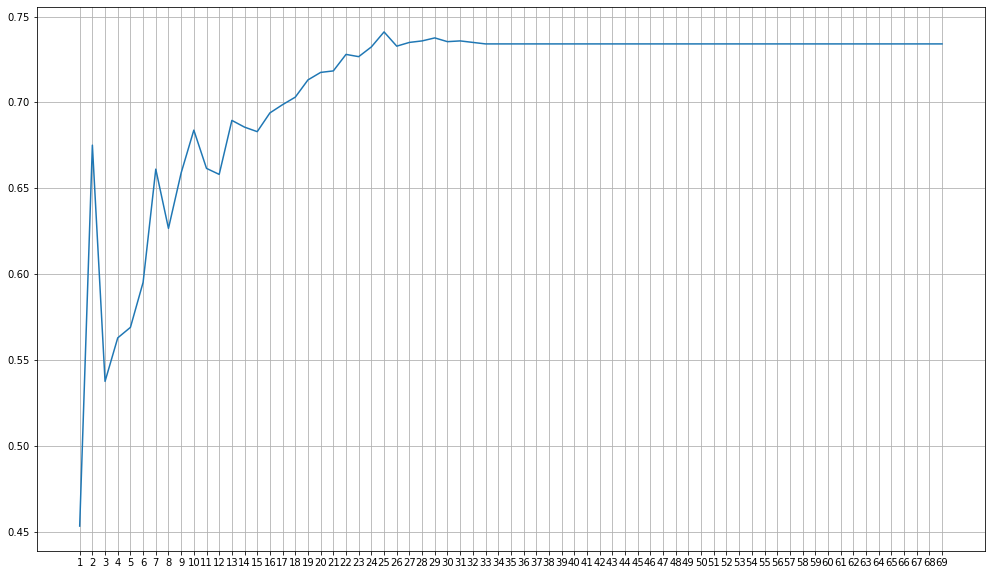

In [36]:
plt.figure(figsize=(17,10))
sns.lineplot(x=range(1,70),y=maxDepth_gini)
plt.xticks(range(1,70))
plt.grid()

La mejor opcion es de 25

In [37]:
max(maxDepth_gini)

0.7410480349344978

#### Buscamos la mejor profundidad probando con el criterio ENTROPY

In [38]:
maxDepth_entropy = []
for m in range(1,70,1):
    maxDepth_entropy.append(evaluar_tree(train_x_scaler,test_x_scaler,m,'entropy'))

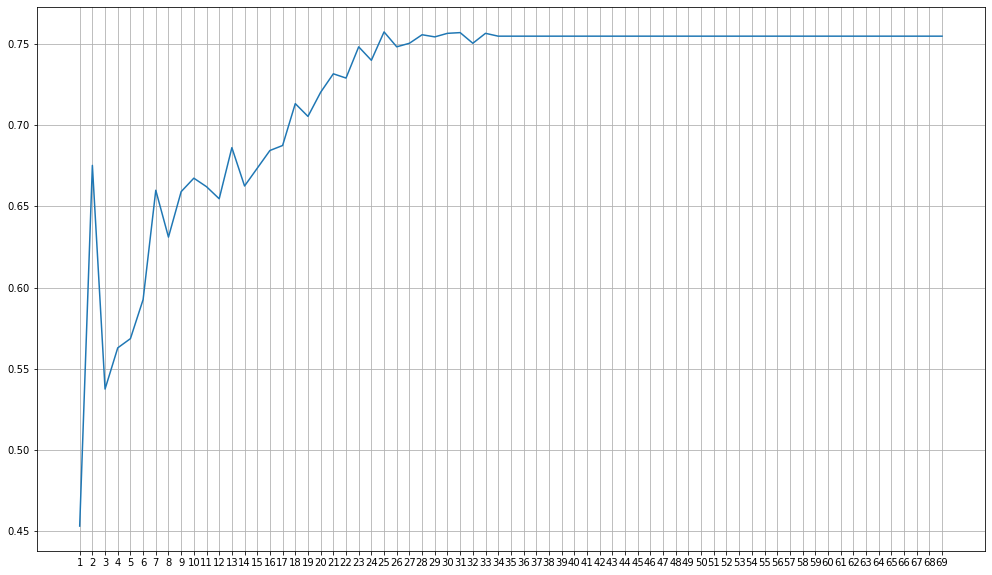

In [39]:
plt.figure(figsize=(17,10))
sns.lineplot(x=range(1,70),y=maxDepth_entropy)
plt.xticks(range(1,70))
plt.grid()

La mejor opcion es de 25

In [40]:
max(maxDepth_entropy)

0.7572052401746725

### Usando OrdinalEncoder

In [41]:
maxDepth_gini2 = []
for m in range(1,70,1):
    maxDepth_gini2.append(evaluar_tree(train_x_scaler2,test_x_scaler2,m,'gini'))

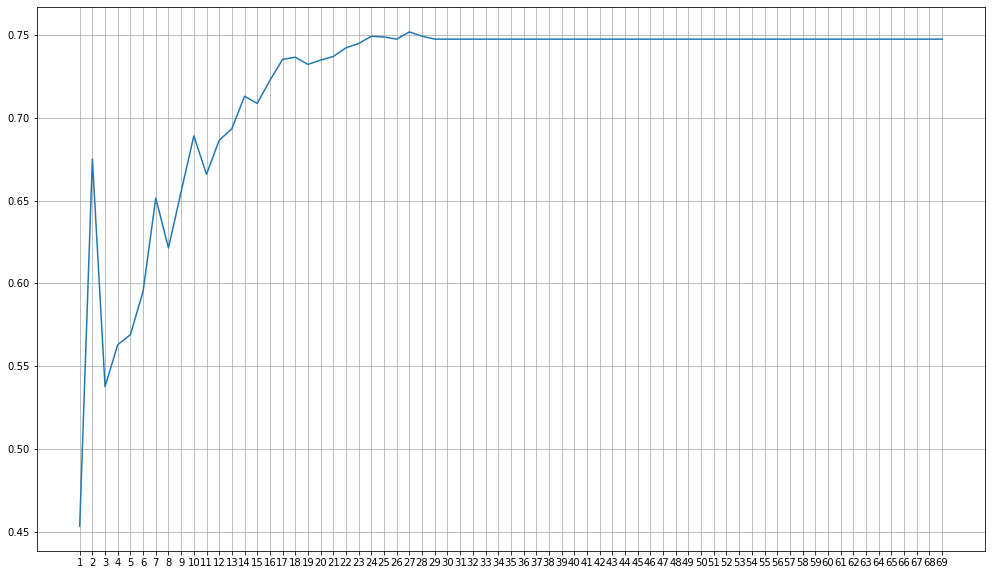

In [42]:
plt.figure(figsize=(17,10))
sns.lineplot(x=range(1,70),y=maxDepth_gini2)
plt.xticks(range(1,70))
plt.grid()

In [43]:
max(maxDepth_gini2)

0.7519650655021834

In [44]:
maxDepth_entropy2 = []
for m in range(1,70,1):
    maxDepth_entropy2.append(evaluar_tree(train_x_scaler2,test_x_scaler2,m,'entropy'))

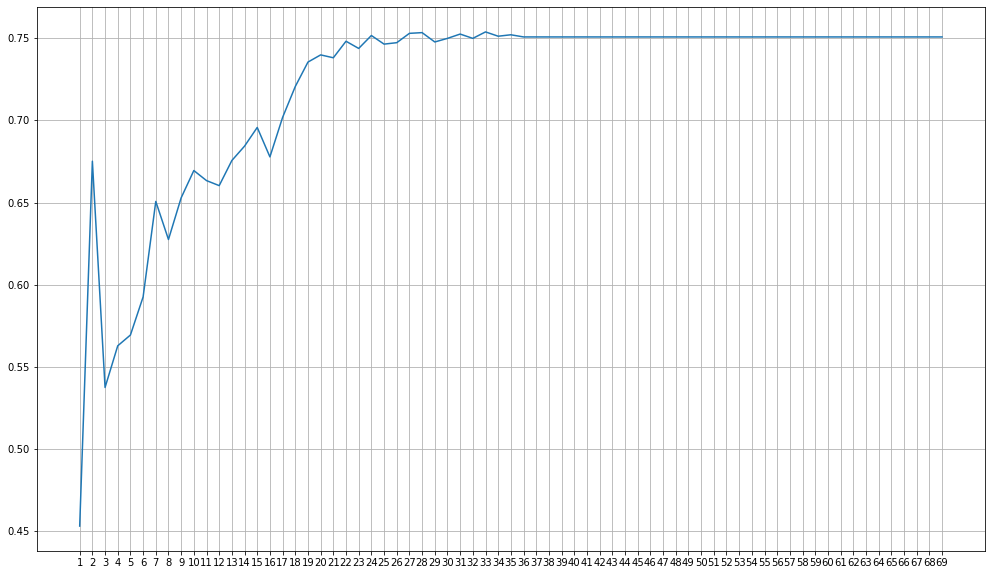

In [45]:
plt.figure(figsize=(17,10))
sns.lineplot(x=range(1,70),y=maxDepth_entropy2)
plt.xticks(range(1,70))
plt.grid()

In [46]:
max(maxDepth_entropy2)

0.7537117903930131

#### **> La mejor opcion es usando *OneHotEncoder, DecissionTreeClassifier, Entropy Y MAX_DEPTH=25(Por ahora) = 0.7572052401746725***

# Prediciendola data de E-Commerce_test.xlsx

In [47]:
ecommerce = pd.read_excel('../Data/E-Commerce_test.xlsx')

In [48]:
ecommerce.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms
0,9000,F,Ship,5,1,189,2,medium,M,10,5248
1,9001,D,Ship,5,3,150,2,high,F,9,4446
2,9002,F,Ship,3,3,200,3,low,M,3,5739
3,9003,A,Ship,5,1,133,2,medium,M,1,4643
4,9004,B,Ship,4,2,260,3,low,M,4,5504


Elimino el ID

In [49]:
ecommerce.drop(columns=['ID'],inplace=True)

Transformo las variables categoricas

In [50]:
test = pd.DataFrame(oneho.fit_transform(ecommerce[categoricos]))

Les cambio de nombre a las columnas

In [51]:
test.columns =["Warehouse_block_a","Warehouse_block_b","Warehouse_block_c","Warehouse_block_d","Warehouse_block_f","Mode_of_Shipment_flight","Mode_of_Shipment_road","Mode_of_Shipment_ship","Product_importance_high","Product_importance_low","Product_importance_medium","Gender_F","Gender_M"]

Elimino las columnas categoricas anteriores

In [52]:
ecommerce.drop(columns=categoricos,inplace=True)

In [53]:
ecommerce

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms
0,5,1,189,2,10,5248
1,5,3,150,2,9,4446
2,3,3,200,3,3,5739
3,5,1,133,2,1,4643
4,4,2,260,3,4,5504
...,...,...,...,...,...,...
1995,4,1,252,5,1,1538
1996,4,1,232,5,6,1247
1997,5,4,242,5,4,1155
1998,5,2,223,6,2,1210


Concateno los datos que quedaron de Ecommerce y los que me genero el OneHot en el dataFrame test

In [54]:
final = pd.concat([ecommerce,test],axis=1)

In [55]:
final

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Warehouse_block_a,Warehouse_block_b,Warehouse_block_c,Warehouse_block_d,Warehouse_block_f,Mode_of_Shipment_flight,Mode_of_Shipment_road,Mode_of_Shipment_ship,Product_importance_high,Product_importance_low,Product_importance_medium,Gender_F,Gender_M
0,5,1,189,2,10,5248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1,5,3,150,2,9,4446,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
2,3,3,200,3,3,5739,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,5,1,133,2,1,4643,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,4,2,260,3,4,5504,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,4,1,252,5,1,1538,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1996,4,1,232,5,6,1247,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1997,5,4,242,5,4,1155,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1998,5,2,223,6,2,1210,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


Estandarizo los datos

In [56]:
standar = StandardScaler()
test_scaler = pd.DataFrame(standar.fit_transform(final))

In [57]:
test_scaler.columns = final.columns

Realizo la prediccion con las variables que se evaluaron y dieron un mejor performance

In [58]:
prediccion_final = prediccion_real(train_x_scaler,test_scaler,25,'entropy')

Creo mi dataFrame

In [60]:
df = pd.DataFrame({"pred":prediccion_final})

In [61]:
df

,pred
0,1
1,1
2,0
3,0
4,1
...,...
1995,0
1996,1
1997,1
1998,1


Guardo la data

In [62]:
df.to_csv("../Edward-Htc.csv",index=False)